Problem Statement

Do you trust all the news you hear from social media? All news are not real, right? So how will you detect the fake news? The answer is Python. By practicing this advanced python project of detecting fake news, you will easily make a difference between real and fake news.

A type of yellow journalism, fake news encapsulates pieces of news that may be hoaxes and is generally spread through social media and other online media. This is often done to further or impose certain ideas and is often achieved with political agendas. Such news items may contain false and/or exaggerated claims, and may end up being viralized by algorithms, and users may end up in a filter bubble.

Import libraries

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Load dataset

The first column identifies the news, the second and third are the title and text, and the fourth column has labels denoting whether the news is REAL or FAKE.

In [91]:
# load datasets
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/news.csv')
df

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL
...,...,...,...,...
6330,4490,State Department says it can't find emails fro...,The State Department told the Republican Natio...,REAL
6331,8062,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,FAKE
6332,8622,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,FAKE
6333,4021,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",REAL


Rename column

In [92]:
df = df.rename(columns = {'Unnamed: 0':'news'})


Analyse data

In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   news    6335 non-null   int64 
 1   title   6335 non-null   object
 2   text    6335 non-null   object
 3   label   6335 non-null   object
dtypes: int64(1), object(3)
memory usage: 198.1+ KB


Check for missing values

In [94]:
df.isnull().sum()

news     0
title    0
text     0
label    0
dtype: int64

Analyse label

In [95]:
target_count = df.groupby('label').label.count()
target_count

label
FAKE    3164
REAL    3171
Name: label, dtype: int64

In [96]:
percent_target = (target_count / len(df)) * 100
percent_target


label
FAKE    49.944751
REAL    50.055249
Name: label, dtype: float64

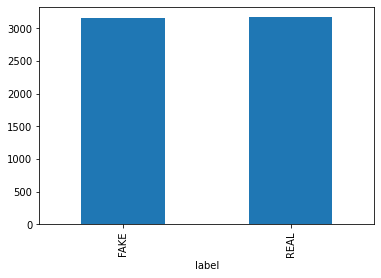

In [97]:
df.groupby('label').label.count().plot.bar(ylim=0)
plt.show()

Map label

In [98]:
dic = {'REAL':1 ,'FAKE':0}
df.label = df.label.map(dic)
df

,news,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",0
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,0
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,1
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",0
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,1
...,...,...,...,...
6330,4490,State Department says it can't find emails fro...,The State Department told the Republican Natio...,1
6331,8062,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,0
6332,8622,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,0
6333,4021,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",1


Preprocess raw text and get ready for machine learning

In [99]:
# Importing HTMLParser
from html.parser import HTMLParser
html_parser = HTMLParser()

In [100]:
# Created a new columns i.e. clean_tweet contains the same tweets but cleaned version
df['processedtext'] = df['text'].apply(lambda x: html_parser.unescape(x))

In [101]:
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')
import re
import warnings
warnings.filterwarnings('ignore')

stemmer = PorterStemmer()
words = stopwords.words("english")

df['processedtext'] = df['processedtext'].apply(lambda x: " ".join([stemmer.stem(i) 
for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in words]).lower())


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [102]:
#make all words lower case
df['processedtext'] = df['processedtext'].str.lower()

# remove special characters, numbers, punctuations
df['processedtext'] = df['processedtext'].str.replace("[^a-zA-Z#]", " ")

#remove words less than 3 characters
df['processedtext'] = df['processedtext'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

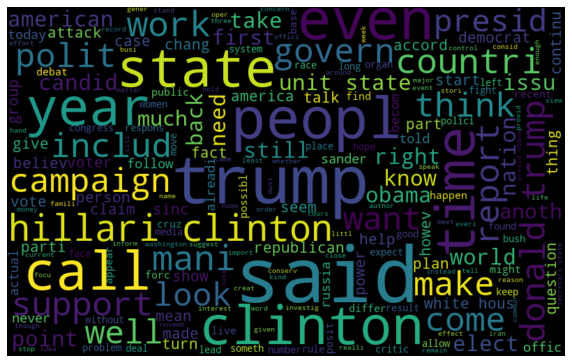

In [103]:
fake_words = ' '.join([text for text in df['processedtext']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(fake_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Define X and y

In [104]:
#define X and y
y = df['label']
X = df['processedtext']

Convert text to word frequency vectors

In [105]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer_tfidf = TfidfVectorizer(stop_words='english', max_df=0.7)
df_tfIdf = vectorizer_tfidf.fit_transform(X.values.astype('U'))
print(vectorizer_tfidf.get_feature_names()[:10])

['aaahhh', 'aachen', 'aadhar', 'aadmi', 'aaeeb', 'aaib', 'aaingr', 'aakar', 'aakhri', 'aalia']


Split X for training and validation

In [106]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(df_tfIdf, y, test_size=0.10, random_state=1, shuffle=True)
X_train.shape, X_val.shape, y_train.shape,y_val.shape

((5701, 40722), (634, 40722), (5701,), (634,))

Select model

Passive Aggressive algorithms are online learning algorithms. Such an algorithm remains passive for a correct classification outcome, and turns aggressive in the event of a miscalculation, updating and adjusting. Unlike most other algorithms, it does not converge. Its purpose is to make updates that correct the loss, causing very little change in the norm of the weight vector.

In [107]:
from sklearn.linear_model import PassiveAggressiveClassifier

model = PassiveAggressiveClassifier(max_iter=10000, random_state=1,tol=1e-3).fit(X_train, y_train)
print(model.score(X_train, y_train))

1.0


Predict on validation set

In [108]:
y_pred = model.predict(X_val)
print(model.score(X_val, y_val))

0.9511041009463722


Confusion matrix

In [109]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_val,y_pred))

[[301  15]
 [ 16 302]]


In [110]:
df_val = pd.DataFrame({'Actual': y_val, 'Predicted':y_pred})
df_val

,Actual,Predicted
3553,1,1
5826,0,0
6140,0,0
2487,1,1
1720,0,0
...,...,...
5156,1,1
1351,0,0
4954,1,1
5093,0,0
